## __Confidence Intervals__

This tutorial demonstrates how to construct confidence intervals for the difference between two population proportions, and for the difference between two population means.  These are two of the most common settings where confidence intervals arise.

__Goals__

1. To illustrate comparison of population proportions, we will analyze the difference between the proportion of females who smoke, and the proportion of males who smoke.  The column that specifies smoker and non-smoker is "SMQ020" in our dataset.

2. To illustrate comparison of population means, we will analyze the difference between mean body mass index (BMI) for females and for males.  The column that has the body mass index values is "BMXBMI".

Additionally, the gender is specified in the column "RIAGENDR".

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
da = pd.read_csv('nhanes_2015_2016.csv')

__Recoding some variables and inspecting the data__

We recode the smoking status variable [SMQ020](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/SMQ_I.htm#SMQ020) that is coded 1 (smoker) / 2 (non-smoker) into a new variable SMQ020x that is coded smoke / nosmoke (refused/don't know are coded as missing):

In [3]:
da['SMQ020x'] = da['SMQ020'].replace({1:'smoke',2:'nosmoke',7:np.nan,9:np.nan})

There are slightly more non-smokers than smokers

In [4]:
da['SMQ020x'].value_counts()

SMQ020x
nosmoke    3406
smoke      2319
Name: count, dtype: int64

Next we recode [RIAGENDR](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIAGENDR) that is coded 1 (male) / 2 (female) to a new variable RIAGENDRx that is coded with string labels. 

In [5]:
da['RIAGENDRx'] = da['RIAGENDR'].replace({1:'Male',2:'Female'})
da['RIAGENDRx'].value_counts()

RIAGENDRx
Female    2976
Male      2759
Name: count, dtype: int64

The joint distribution of dmoking and gender variables is conveyed by a cross-tab

In [7]:
dx = da[['SMQ020x','RIAGENDRx']].dropna()
ct = pd.crosstab(dx['RIAGENDRx'],dx['SMQ020x'])
ct

SMQ020x,nosmoke,smoke
RIAGENDRx,,
Female,2066,906
Male,1340,1413


Next we estimate the conditional rates of smoking in females and in males.

In [8]:
ct['Total'] = ct['nosmoke'] + ct['smoke']
ct['nosmoke_prop'] = ct['nosmoke']/ct['Total']
ct['smoke_prop'] = ct['smoke']/ct['Total']
ct

SMQ020x,nosmoke,smoke,Total,nosmoke_prop,smoke_prop
RIAGENDRx,,,,,
Female,2066,906,2972,0.695155,0.304845
Male,1340,1413,2753,0.486742,0.513258


$$
{\rm SE}_{\rm pooled} = \sqrt{{\rm SE}_1^2 + {\rm SE}_2^2}.
$$

Note that this version of the variance pooling rule can only be used when the two estimates being compared (e.g. the estimated rates or means for two groups) are independent.

__Difference of Two Population Proportions__

Based on the table calculated above, we see that a much higher proportion of males smoke compared to females. The point estimate of this difference is:

In [9]:
di = ct.loc['Male']['smoke_prop']-ct.loc['Female']['smoke_prop']
di

np.float64(0.20841304163963553)

Suppose we wish to assess the precision of the estimate in the cell above. First, we assess the precision of the female and male smoking rates individually:

In [11]:
pf = ct.loc['Female']['smoke_prop']
nf = ct.loc['Female']['Total']
se_female= np.sqrt((pf*(1-pf))/nf)
se_female

np.float64(0.008444152146214435)

In [12]:
pm = ct.loc['Male']['smoke_prop']
nm = ct.loc['Male']['Total']
se_male = np.sqrt((pm*(1-pm))/nm)
se_male

np.float64(0.009526078653689868)

As seen above, the precisions of the female-specific and male-specific smoking rates are quite similar, although the female rate is slightly smaller. The standard error of the difference between the female and male smoking rates can be obtained by pooling the standard error for females and the standard error for males:

In [13]:
se_diff = np.sqrt(se_female**2 + se_male**2)
se_diff

np.float64(0.012729881381407434)

As we can see above, the standard error for the difference between two proportions is slightly greater than the standard error for either proportion individually. Now we can construct a 95% confidence interval for the difference between the male and female smoking rates. We see that any value for the proportion that falls between 0.18 and 0.23 would be compatible with the data.

In [14]:
lcb = di - 1.96 * se_diff
ucb = di + 1.96 * se_diff
(lcb,ucb)

(np.float64(0.18346247413207697), np.float64(0.2333636091471941))

__Difference of Two Population Means__

Now we consider estimation of the mean BMI (body mass index) for females and for males, and comparing these means.  The NHANES variable containing BMI is [BMXBMI](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXBMI).  The first few BMI values are as follows:

In [15]:
da['BMXBMI'].head()

0    27.8
1    30.8
2    28.8
3    42.4
4    20.3
Name: BMXBMI, dtype: float64

The sex-specific mean, standard deviation, and sample size for BMI is:

In [18]:
ta = da.groupby('RIAGENDRx').agg({'BMXBMI':['mean','std',np.size]})
ta

BMXBMI                
                mean       std  size
RIAGENDRx                           
Female     29.939946  7.753319  2976
Male       28.778072  6.252568  2759

Based on the table above, we see that females have somewhat higher BMI than males. It is important to note that while the means may differ, the standard deviation is large so there is substantial overlap between the two distributions. The boxplot below indicates how the two distributions overlap, while also suggesting that the female BMI distribution has a slightly higher mean and perhaps greater dispersion.

<Axes: xlabel='RIAGENDRx', ylabel='BMXBMI'>

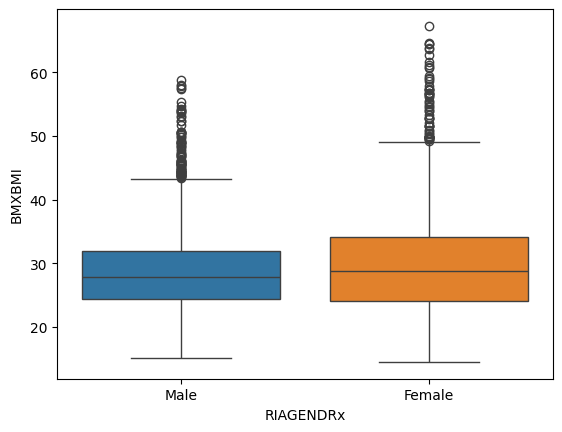

In [20]:
sns.boxplot(x = 'RIAGENDRx', y = 'BMXBMI', data = da, hue = 'RIAGENDRx')

Next we calculate the standard errors of the mean for females and for males:

In [22]:
sem_female = ta.loc['Female',('BMXBMI','std')]/np.sqrt(ta.loc['Female',('BMXBMI','size')])
sem_male = ta.loc['Male',('BMXBMI','std')]/np.sqrt(ta.loc['Male',('BMXBMI','size')])
(sem_female,sem_male)

(np.float64(0.14212522940758335), np.float64(0.11903715722332033))

The standard errors above indicate that when estimating the population mean BMI values for females and for males, the female estimate will be slightly less precise. This reduced precision is largely due to the greater internal variability of the female BMI values.

In [23]:
sem_diff = np.sqrt(sem_female**2 + sem_male**2)
sem_diff

np.float64(0.18538992862064455)

The difference below is the point estimate of interest:

In [24]:
di = ta.loc["Female", ("BMXBMI", "mean")] - ta.loc["Male", ("BMXBMI", "mean")]

In [25]:
lcb = di - 1.96 * sem_diff
ucb = di + 1.96 * sem_diff
(lcb, ucb)

(np.float64(0.798509280230502), np.float64(1.5252378004234286))